In [1]:
import torch
import torch.nn as nn
from torchvision import models
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image
import json

In [2]:
alexnet = models.alexnet(weights='DEFAULT')
alexnet.eval()
with open("../labels.json", "r") as f:
    label_names = json.loads(f.read())

In [3]:
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

def transform_for_plt_imshow(image_tensor):
    return transforms.Compose([
        transforms.Normalize(mean=[0, 0, 0], std=[4.3668122, 4.4642857, 4.4444444]),
        transforms.Normalize(mean=[-0.485, -0.456, -0.406], std = 1)
    ])(image_tensor).permute(1, 2, 0)

def generate_vertical_translations(image_tensor, h = 80, l = 80, n = 25):
    translations = [
        transforms.Compose([transforms.Resize(256, antialias=True),
    transforms.CenterCrop(224)])(image_tensor[:,x * (224 - h) // n:x * (224 - h) // n + h,l:l + h]).tolist()
        for x in range(n)
    ]
    return torch.tensor(translations)
def generate_rotations(image_tensor, n = 25):
    theta = 360 / n
    rotations = [transforms.functional.rotate(image_tensor, angle = x * theta).tolist() for x in range(n)]
    return torch.tensor(rotations), torch.tensor([x * theta for x in range(n)])
def generate_scaled_images(image_tensor, n = 25):
    min_size = int(image_tensor.shape[1] // 2)
    max_size = image_tensor.shape[1]
    y = (max_size - min_size) // n
    scaled_images = [
        transforms.Compose([
            transforms.CenterCrop(x),
            transforms.Resize(256, antialias = True),
            transforms.CenterCrop(224)
        ])(image_tensor).tolist()
        for x in range(max_size, min_size + y, -y)
    ]
    return torch.tensor(scaled_images), torch.tensor([max_size / x for x in range(max_size, min_size + y, -y)])

In [4]:
class AlexnetLayers(nn.Module):
    def __init__(self):
        super(AlexnetLayers, self).__init__()
        self.conv2d_1 = nn.Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
        self.relu_1 = nn.ReLU(inplace=True)
        self.maxPool2d_1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
        self.conv2d_2 = nn.Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
        self.relu_2 = nn.ReLU(inplace=True)
        self.maxPool2d_2 = nn.MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
        self.conv2d_3 = nn.Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.relu_3 = nn.ReLU(inplace=True)
        self.conv2d_4 = nn.Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.relu_4 = nn.ReLU(inplace=True)
        self.conv2d_5 = nn.Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.relu_5 = nn.ReLU(inplace=True)
        self.maxPool2d_5 = nn.MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
        self.avgpool = nn.AdaptiveAvgPool2d(output_size=(6, 6))
        self.dropout_6 = nn.Dropout(p=0.5, inplace=False)
        self.linear_6 = nn.Linear(in_features=9216, out_features=4096, bias=True)
        self.relu_6 = nn.ReLU(inplace=True)
        self.dropout_7 = nn.Dropout(p=0.5, inplace=False)
        self.linear_7 = nn.Linear(in_features=4096, out_features=4096, bias=True)
        self.relu_7 = nn.ReLU(inplace=True)
        self.linear_8 = nn.Linear(in_features=4096, out_features=1000, bias=True)
    def forward(self, x, layer = 1):
        x = self.conv2d_1(x)
        self.relu_1(x)
        if(layer >= 2):
            x = self.maxPool2d_1(x)
            x = self.conv2d_2(x)
            self.relu_2(x)
        if(layer >= 3):
            x = self.maxPool2d_2(x)
            x = self.conv2d_3(x)
            self.relu_3(x)
        if(layer >= 4):
            x = self.conv2d_4(x)
            self.relu_4(x)
        if(layer >= 5):
            x = self.conv2d_5(x)
            self.relu_5(x)
        if(layer >= 6):
            x = self.maxPool2d_5(x)
            x = self.avgpool(x)
            x = x.view(x.size(0), -1)
            x = self.dropout_6(x)
            x = self.linear_6(x)
            self.relu_6(x)
        if(layer >= 7):
            x = self.dropout_7(x)
            x = self.linear_7(x)
            self.relu_7(x)
        if(layer >= 8):
            x = self.linear_8(x)
        return x

alexnetLayers = AlexnetLayers()

alexnetLayers.conv2d_1.weight.data = alexnet.state_dict()['features.0.weight'].clone().detach()
alexnetLayers.conv2d_1.bias.data = alexnet.state_dict()['features.0.bias'].clone().detach()
alexnetLayers.conv2d_2.weight.data = alexnet.state_dict()['features.3.weight'].clone().detach()
alexnetLayers.conv2d_2.bias.data = alexnet.state_dict()['features.3.bias'].clone().detach()
alexnetLayers.conv2d_3.weight.data = alexnet.state_dict()['features.6.weight'].clone().detach()
alexnetLayers.conv2d_3.bias.data = alexnet.state_dict()['features.6.bias'].clone().detach()
alexnetLayers.conv2d_4.weight.data = alexnet.state_dict()['features.8.weight'].clone().detach()
alexnetLayers.conv2d_4.bias.data = alexnet.state_dict()['features.8.bias'].clone().detach()
alexnetLayers.conv2d_5.weight.data = alexnet.state_dict()['features.10.weight'].clone().detach()
alexnetLayers.conv2d_5.bias.data = alexnet.state_dict()['features.10.bias'].clone().detach()
alexnetLayers.linear_6.weight.data = alexnet.state_dict()['classifier.1.weight'].clone().detach()
alexnetLayers.linear_6.bias.data = alexnet.state_dict()['classifier.1.bias'].clone().detach()
alexnetLayers.linear_7.weight.data = alexnet.state_dict()['classifier.4.weight'].clone().detach()
alexnetLayers.linear_7.bias.data = alexnet.state_dict()['classifier.4.bias'].clone().detach()
alexnetLayers.linear_8.weight.data = alexnet.state_dict()['classifier.6.weight'].clone().detach()
alexnetLayers.linear_8.bias.data = alexnet.state_dict()['classifier.6.bias'].clone().detach()

alexnetLayers.eval()

AlexnetLayers(
  (conv2d_1): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
  (relu_1): ReLU(inplace=True)
  (maxPool2d_1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2d_2): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (relu_2): ReLU(inplace=True)
  (maxPool2d_2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2d_3): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu_3): ReLU(inplace=True)
  (conv2d_4): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu_4): ReLU(inplace=True)
  (conv2d_5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu_5): ReLU(inplace=True)
  (maxPool2d_5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (dropout_6): Dropout(p=0.5, inplace=False)
  (linear_6): Linear(in_features=9216, out_feature

['impala, Aepyceros melampus', 'dishrag, dishcloth', 'organ, pipe organ', 'zebra', 'tennis ball']


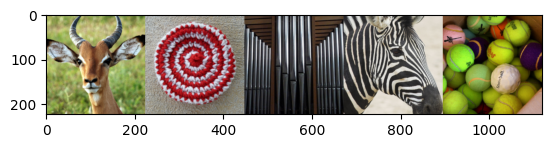

In [5]:
images = []
images.append(Image.open("../images/31.JPEG"))
images.append(Image.open("../images/15.JPEG"))
images.append(Image.open("../images/1.JPEG"))
images.append(Image.open("../images/38.JPEG"))
images.append(Image.open("../images/24.JPEG"))
# plt.imshow(image)
image_tensors = [transform(image) for image in images]
# print(image_tensor.shape)

# image_tensors[3] = transforms.Compose([transforms.Resize(256), transforms.CenterCrop(224)])(image_tensors[3][:,60:,:])

plt.imshow(transform_for_plt_imshow(torch.concat(image_tensors, dim = 2)))
image_tensors = torch.tensor([image_tensor.tolist() for image_tensor in image_tensors])

label_indices = torch.argmax(alexnet(image_tensors), dim = 1)
image_labels = [label_names[str(x.item())] for x in label_indices]
print(image_labels)

In [6]:
def stack_transformed_images_to_show(images, n):
    # takes list of list
    return torch.concat([torch.concat([x[i] for i in range(0, len(x), int(np.ceil(len(x) // n)))], dim = 2) for x in images], dim = 1)

## Translation

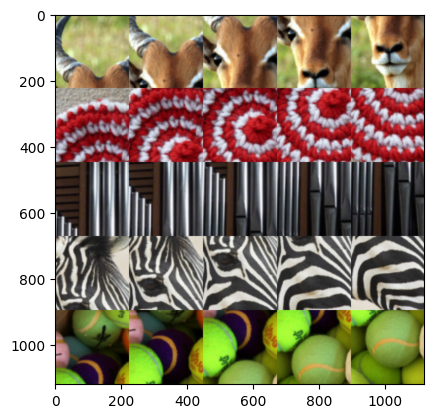

In [7]:
vertically_translated_images = [0] * len(image_tensors)

h = 90; n = 100
vertically_translated_images[0] = generate_vertical_translations(image_tensors[0], h = h, l = 55, n = n)
vertically_translated_images[1] = generate_vertical_translations(image_tensors[1], h = h, l = 50, n = n)
vertically_translated_images[2] = generate_vertical_translations(image_tensors[2], h = h, l = 30, n = n)
vertically_translated_images[3] = generate_vertical_translations(image_tensors[3], h = h, l = 90, n = n)
vertically_translated_images[4] = generate_vertical_translations(image_tensors[4], h = h, l = 30, n = n)

translations = np.array([x * (224 - h) // n for x in range(n)])

plt.imshow(transform_for_plt_imshow(stack_transformed_images_to_show(vertically_translated_images, 5)))

# plt.imshow(transform_for_plt_imshow(torch.cat([x for x in vertically_translated_images[0]], dim = 2)))
# plt.imshow(transform_for_plt_imshow(vertically_translated_images[8]))

plt.savefig("./translation_images.png")

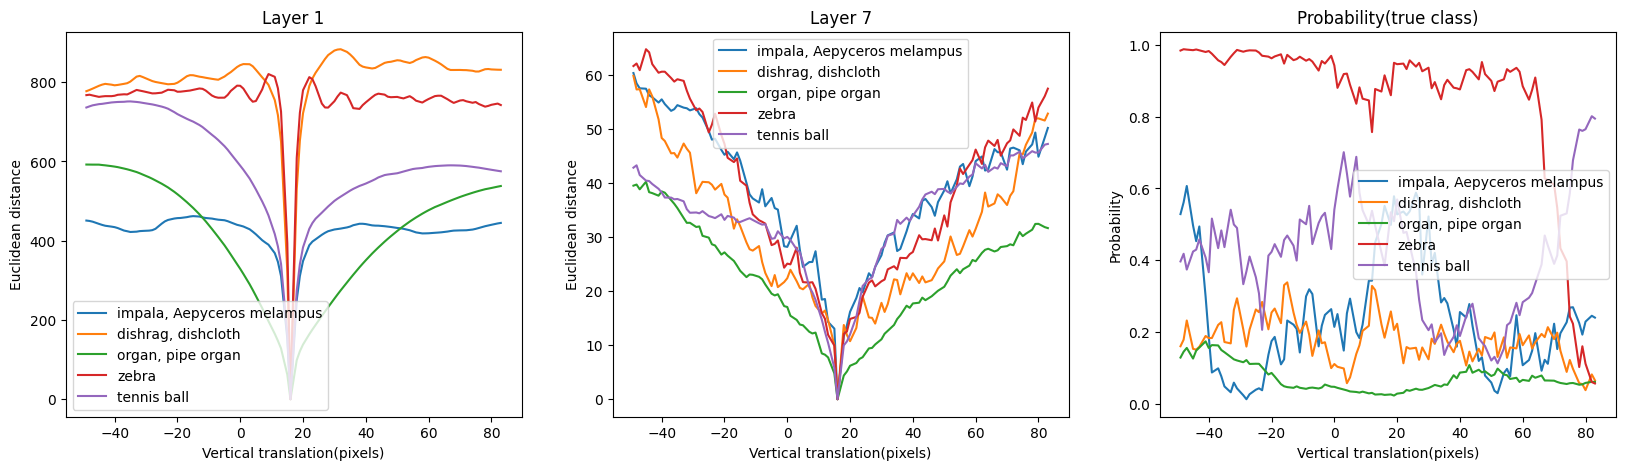

In [8]:
translations = translations - (len(translations) - 1) // 2 * (translations[1] - translations[0])

vertically_translated_images_outputs_layer_1 = [alexnetLayers(x, layer = 1).reshape(len(x), -1) for x in vertically_translated_images]
original_image_outputs_layer_1 = [x[(len(x) - 1) // 2] for x in vertically_translated_images_outputs_layer_1]
translation_distances_layer_1 = [[torch.norm(original_image_outputs_layer_1[i] - x, p = 2).item() for x in vertically_translated_images_outputs_layer_1[i]] for i in range(len(vertically_translated_images_outputs_layer_1))]


vertically_translated_images_outputs_layer_7 = [alexnetLayers(x, layer = 7).reshape(len(x), -1) for x in vertically_translated_images]
original_image_outputs_layer_7 = [x[(len(x) - 1) // 2] for x in vertically_translated_images_outputs_layer_7]
translation_distances_layer_7 = [[torch.norm(original_image_outputs_layer_7[i] - x, p = 2).item() for x in vertically_translated_images_outputs_layer_7[i]] for i in range(len(vertically_translated_images_outputs_layer_7))]

vertically_translated_images_outputs = [alexnet(x) for x in vertically_translated_images]
vertically_translated_images_probabilities = [(torch.exp(vertically_translated_images_outputs[i])[:,label_indices[i]] / torch.sum(torch.exp(vertically_translated_images_outputs[i]), dim = 1)).tolist() for i in range(len(image_tensors))]

fig, ax = plt.subplots(1, 3, figsize = (20, 5))

for i in range(len(image_tensors)):
    ax[0].plot(translations, translation_distances_layer_1[i], label = image_labels[i])
    ax[1].plot(translations, translation_distances_layer_7[i], label = image_labels[i])
    ax[2].plot(translations, vertically_translated_images_probabilities[i], label = image_labels[i])

ax[0].set(title = "Layer 1", ylabel = "Euclidean distance", xlabel = "Vertical translation(pixels)")
ax[1].set(title = "Layer 7", ylabel = "Euclidean distance", xlabel = "Vertical translation(pixels)")
ax[2].set(title = "Probability(true class)", ylabel = "Probability", xlabel = "Vertical translation(pixels)")

[ax[i].legend() for i in range(len(ax))]

fig.savefig("./translation_plots.png")

## Scaling

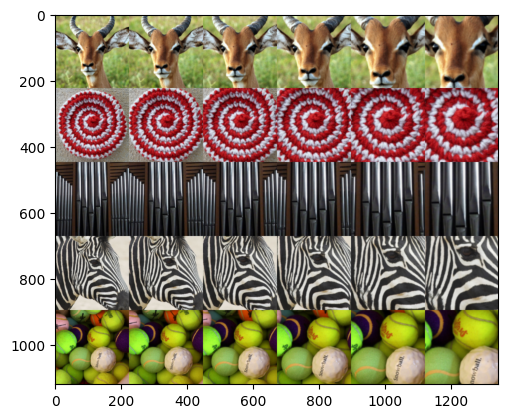

In [9]:
n = 100
scaled_images = [0] * len(image_tensors)
scaled_images[0], scales = generate_scaled_images(image_tensors[0], n = n)
scaled_images[1], scales = generate_scaled_images(image_tensors[1], n = n)
scaled_images[2], scales = generate_scaled_images(image_tensors[2], n = n)
scaled_images[3], scales= generate_scaled_images(image_tensors[3], n = n)
scaled_images[4], scales = generate_scaled_images(image_tensors[4], n = n)

plt.imshow(transform_for_plt_imshow(stack_transformed_images_to_show(scaled_images, 5)))

# plt.imshow(transform_for_plt_imshow(torch.cat([x for x in scaled_images[0]], dim = 2)))
# plt.imshow(transform_for_plt_imshow(scaled_images[8]))

plt.savefig("./scaling_images.png")

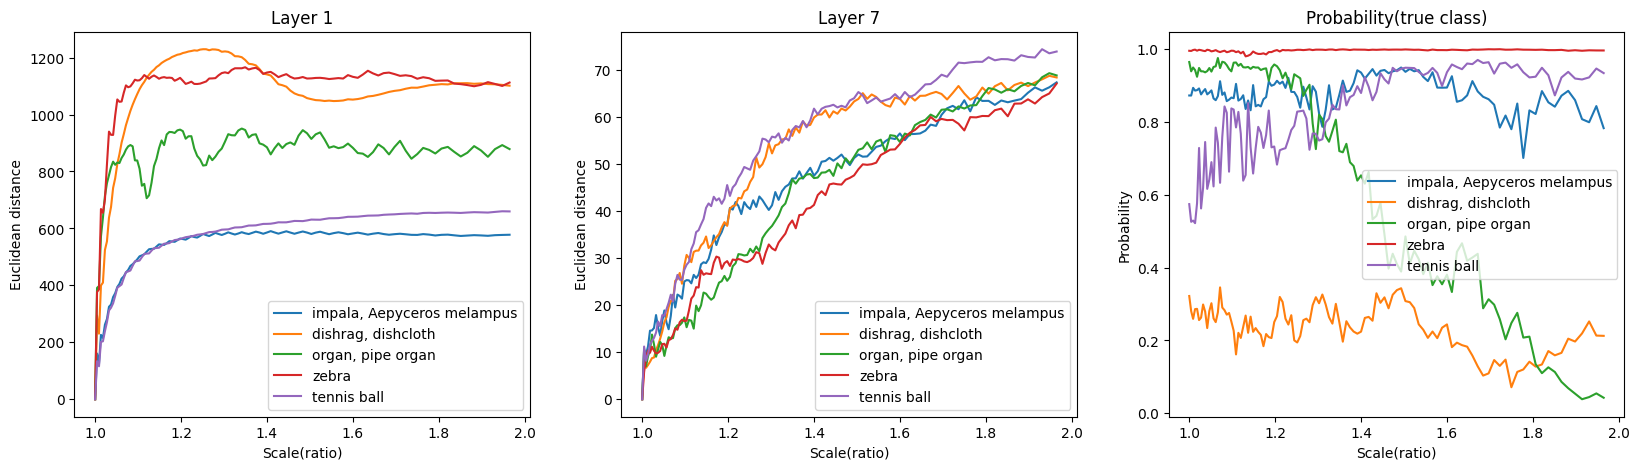

In [11]:
scaled_images_outputs_layer_1 = [alexnetLayers(x, layer = 1).reshape(len(x), -1) for x in scaled_images]
original_image_outputs_layer_1 = [x[0] for x in scaled_images_outputs_layer_1]
scaling_distances_layer_1 = [[torch.norm(original_image_outputs_layer_1[i] - x, p = 2).item() for x in scaled_images_outputs_layer_1[i]] for i in range(len(scaled_images_outputs_layer_1))]


scaled_images_outputs_layer_7 = [alexnetLayers(x, layer = 7).reshape(len(x), -1) for x in scaled_images]
original_image_outputs_layer_7 = [x[0] for x in scaled_images_outputs_layer_7]
scaling_distances_layer_7 = [[torch.norm(original_image_outputs_layer_7[i] - x, p = 2).item() for x in scaled_images_outputs_layer_7[i]] for i in range(len(scaled_images_outputs_layer_7))]

scaled_images_outputs = [alexnet(x) for x in scaled_images]
scaled_images_probabilities = [(torch.exp(scaled_images_outputs[i])[:,label_indices[i]] / torch.sum(torch.exp(scaled_images_outputs[i]), dim = 1)).tolist() for i in range(len(image_tensors))]

fig, ax = plt.subplots(1, 3, figsize = (20, 5))

for i in range(len(image_tensors)):
    ax[0].plot(scales, scaling_distances_layer_1[i], label = image_labels[i])
    ax[1].plot(scales, scaling_distances_layer_7[i], label = image_labels[i])
    ax[2].plot(scales, scaled_images_probabilities[i], label = image_labels[i])

ax[0].set(title = "Layer 1", ylabel = "Euclidean distance", xlabel = "Scale(ratio)")
ax[1].set(title = "Layer 7", ylabel = "Euclidean distance", xlabel = "Scale(ratio)")
ax[2].set(title = "Probability(true class)", ylabel = "Probability", xlabel = "Scale(ratio)")

[ax[i].legend() for i in range(len(ax))]

fig.savefig("./scaling_plots.png")

# del scaled_images_outputs_layer_1, original_image_outputs_layer_1, scaling_distances_layer_1, scaled_images_outputs_layer_7, original_image_outputs_layer_7, scaling_distances_layer_7, scaled_images_outputs, scaled_images_probabilities

## Rotations

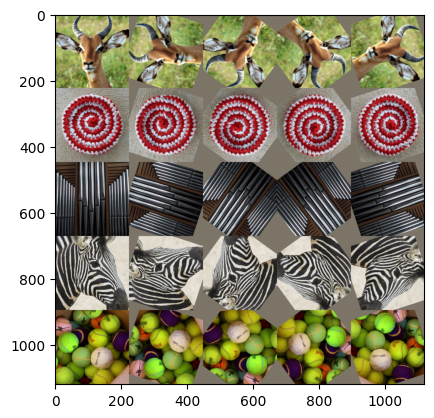

In [7]:
n = 100
rotated_images = [0] * len(image_tensors)
rotated_images[0], rotations = generate_rotations(image_tensors[0], n = n)
rotated_images[1], rotations = generate_rotations(image_tensors[1], n = n)
rotated_images[2], rotations = generate_rotations(image_tensors[2], n = n)
rotated_images[3], rotations= generate_rotations(image_tensors[3], n = n)
rotated_images[4], rotations = generate_rotations(image_tensors[4], n = n)

plt.imshow(transform_for_plt_imshow(stack_transformed_images_to_show(rotated_images, 5)))

# plt.imshow(transform_for_plt_imshow(torch.cat([x for x in rotated_images[0]], dim = 2)))
# plt.imshow(transform_for_plt_imshow(rotated_images[8]))

plt.savefig("./rotation_images.png")

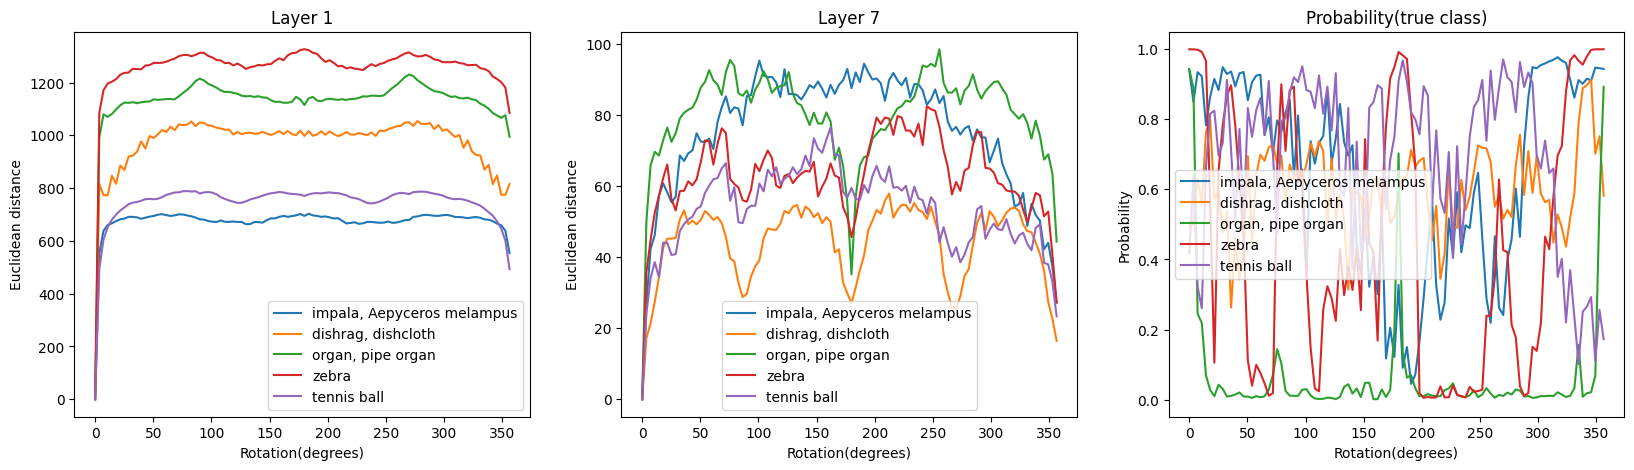

In [8]:
rotated_images_outputs_layer_1 = [alexnetLayers(x, layer = 1).reshape(len(x), -1) for x in rotated_images]
original_image_outputs_layer_1 = [x[0] for x in rotated_images_outputs_layer_1]
rotation_distances_layer_1 = [[torch.norm(original_image_outputs_layer_1[i] - x, p = 2).item() for x in rotated_images_outputs_layer_1[i]] for i in range(len(rotated_images_outputs_layer_1))]


rotated_images_outputs_layer_7 = [alexnetLayers(x, layer = 7).reshape(len(x), -1) for x in rotated_images]
original_image_outputs_layer_7 = [x[0] for x in rotated_images_outputs_layer_7]
rotation_distances_layer_7 = [[torch.norm(original_image_outputs_layer_7[i] - x, p = 2).item() for x in rotated_images_outputs_layer_7[i]] for i in range(len(rotated_images_outputs_layer_7))]

rotated_images_outputs = [alexnet(x) for x in rotated_images]
rotated_images_probabilities = [(torch.exp(rotated_images_outputs[i])[:,label_indices[i]] / torch.sum(torch.exp(rotated_images_outputs[i]), dim = 1)).tolist() for i in range(len(image_tensors))]

fig, ax = plt.subplots(1, 3, figsize = (20, 5))

for i in range(len(image_tensors)):
    ax[0].plot(rotations, rotation_distances_layer_1[i], label = image_labels[i])
    ax[1].plot(rotations, rotation_distances_layer_7[i], label = image_labels[i])
    ax[2].plot(rotations, rotated_images_probabilities[i], label = image_labels[i])

ax[0].set(title = "Layer 1", ylabel = "Euclidean distance", xlabel = "Rotation(degrees)")
ax[1].set(title = "Layer 7", ylabel = "Euclidean distance", xlabel = "Rotation(degrees)")
ax[2].set(title = "Probability(true class)", ylabel = "Probability", xlabel = "Rotation(degrees)")

[ax[i].legend() for i in range(len(ax))]

fig.savefig("./rotation_plots.png")

# del rotated_images_outputs_layer_1, original_image_outputs_layer_1, rotation_distances_layer_1, rotated_images_outputs_layer_7, original_image_outputs_layer_7, rotation_distances_layer_7, rotated_images_outputs, rotated_images_probabilities